In [2]:
import pandas as pd
import numpy as np
import os

dtype = {
            'userID': 'int16',
            'answerCode': 'int8',
            'KnowledgeTag': 'int16'
        }

DATA_PATH = '/opt/ml/input/data'
MODEL_PATH = '/opt/ml/model'

train_df = pd.read_csv(os.path.join(DATA_PATH, 'train_data.csv'), dtype=dtype, parse_dates=['Timestamp'])
train_df = train_df.sort_values(by=['userID', 'Timestamp']).reset_index(drop=True)

test_df = pd.read_csv(os.path.join(DATA_PATH, 'test_data.csv'), dtype=dtype, parse_dates=['Timestamp'])
test_df = test_df.sort_values(by=['userID', 'Timestamp']).reset_index(drop=True)

df = pd.concat([train_df, test_df]).sort_values(by=['userID', 'Timestamp']).reset_index(drop=True)

In [ ]:
from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence
from gensim.models.callbacks import CallbackAny2Vec
import datetime

class callback(CallbackAny2Vec):
    '''Callback to print loss after each epoch.'''

    def __init__(self):
        self.epoch = 1
        self.loss_to_be_subed = 0
        self.loss_now = 987654321

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        loss_now = loss - self.loss_to_be_subed
        print(f'Loss after epoch {self.epoch}: {loss_now}, Total_loss : {loss}')

        self.loss_to_be_subed = loss
        if loss_now < self.loss_now:
            self.loss_now = loss_now
            model.save(os.path.join(MODEL_PATH, 'Word2Vec_Embedding_Model_window_50.model'))
            print('Model 저장')
        self.epoch += 1

start = datetime.datetime.now()

group_df = df.groupby('userID')
sentences = []
for user, g in group_df:
    item_list = g['assessmentItemID'].tolist()
    sentences.append(
        item_list
    )

model = Word2Vec(
                sentences = sentences,
                seed = 22,
                epochs = 30,
                min_count = 1,
                vector_size = 64,
                sg = 1,
                negative = 5,
                window = 50,
                compute_loss = True, 
                callbacks=[callback()],
                 )

print("Time passed: " + str(datetime.datetime.now() - start))

In [13]:
from gensim.models import Word2Vec

# Word2Vec_Embedding_Model_sk_100 / window = 987654321 / negative = 10
# Word2Vec_Embedding_Model_window_50 / window = 50 / negative = 5

model = Word2Vec.load(os.path.join(MODEL_PATH, 'Word2Vec_Embedding_Model_window_50.model'))

assessmentItemID_li = df['assessmentItemID'].unique()

arr = []

assessmentItemID2idx = {}

for idx, assessmentItemID in enumerate(assessmentItemID_li):
    assessmentItemID2idx[assessmentItemID] = idx
    arr.append(model.wv[assessmentItemID])

arr = np.array(arr)

In [14]:
def get_large_paper_number(x):
    return x[1:4]

df['large_paper_number'] = df['assessmentItemID'].apply(lambda x : get_large_paper_number(x))

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state = 0)
new_arr = tsne.fit_transform(arr)

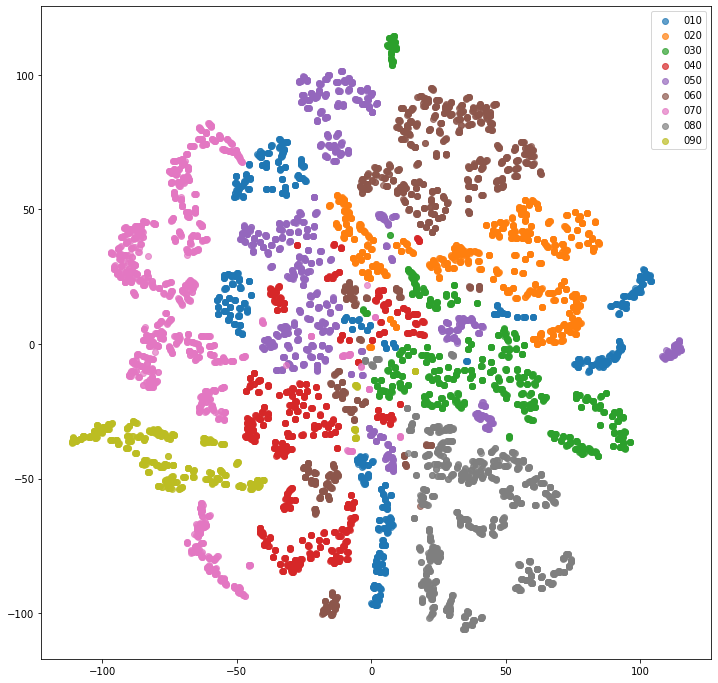

In [16]:
import matplotlib.pyplot as plt

group_df = df.groupby('large_paper_number')

plt.figure(figsize = (12, 12))

for large_paper_number, g_df in group_df:
    assessmentItemID_li = g_df['assessmentItemID'].unique().tolist()
    idx_li = []
    for assessmentItemID in assessmentItemID_li:
        idx_li.append(assessmentItemID2idx[assessmentItemID])
    
    plt.scatter(new_arr[idx_li, 0], new_arr[idx_li, 1], alpha = 0.7, label = f'{large_paper_number}')
    
plt.legend()
plt.show()

서로 비슷하게 출현하는 문항들이 존재하는 것 같으며, 같은 대분류를 갖는 문항이라도 무조건 모든 문항을 푸는 것은 아님